# Impact of Uraza-Bayram on FMCG Sales: A Bootstrapping Analysis

## Project Overview
This project tests the hypothesis that sales of confectionery products significantly increase during the Islamic holiday Uraza-Bayram (Eid al-Fitr) in the Muslim-majority regions of Tatarstan and Bashkortostan, compared to other Russian regions*Treatment + β₃*(Post×Treatment) + ε

## Business Context
While Uraza-Bayram isn't directly associated with chocolate/candy consumption, we hypothesize that:
1. Cultural traditions of gift-giving during holidays drive sales
2. Regional purchasing patterns differ during religious observances
3. The effect is unique to Muslim-majority regions


## Data Description
### Time Periods
- **Pre-holiday period**: Weeks 5-8 (baseline)
- **Holiday period**: Weeks 9-12 (test)

### Dataset Structure
| Column | Description | Type |
|--------|-------------|------|
| Product Code | Unique product identifier | string |
| Technology | Product type/category | string |
| YearWeek | Year and week of sales (YYYYWW) | integer |
| Turnover Qty | Sales volume (tonnage) | float |
| Outlet Region | Russian region where sale occurred | string |

## Methodology
### 1. Data Preparation
- Cleated data
- Removed dublicated values

### 2. Experimental Design
**Test Group**: Tatarstan & Bashkortostan  
**Control Group**: Other Russian regions

### 3. Analysis Approach
**Difference-in-Differences (DiD) Model**:
```math
Y = β₀ + β₁*Post + β₂*Treatment + β₃*(Post×Treatment) + ε

## Importing packages and data

In [234]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import stats as st
from matplotlib.ticker import FuncFormatter

In [235]:
data = pd.read_excel(r'C:\Users\ASUS\Downloads\Uraza.xlsx')

In [236]:
data = data.drop(columns = 'Product') 

In [237]:
data.head(5)

,Product Code,Technology,YearWeek,Turnover Qty,Outlet Region
0,15205,Sticks,2025-05,41.25,Kurgan Oblast
1,15205,Sticks,2025-05,66.00,Nizhny Novgorod Oblast
2,15205,Sticks,2025-05,11.00,Orenburg Oblast
3,15205,Sticks,2025-05,11.00,Perm Krai
4,15205,Sticks,2025-05,41.25,Republic of Bashkortostan


In [238]:
data.describe(include='all')

,Product Code,Technology,YearWeek,Turnover Qty,Outlet Region
count,8.104000e+03,8104,8104,8104.000000,8104
unique,NaN,22,8,NaN,12
top,NaN,Bars,2025-10,NaN,Nizhny Novgorod Oblast
freq,NaN,1564,1341,NaN,1119
mean,4.363490e+06,NaN,NaN,7320.420788,NaN
std,9.126069e+06,NaN,NaN,18159.135015,NaN
min,3.658000e+03,NaN,NaN,0.000000,NaN
25%,3.297592e+06,NaN,NaN,0.000000,NaN
50%,3.641042e+06,NaN,NaN,35.750000,NaN
75%,4.133363e+06,NaN,NaN,6373.125000,NaN


In [239]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8104 entries, 0 to 8103
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Product Code   8104 non-null   int64  
 1   Technology     8104 non-null   object 
 2   YearWeek       8104 non-null   object 
 3   Turnover Qty   8104 non-null   float64
 4   Outlet Region  8104 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 316.7+ KB


In [240]:
data[data['Turnover Qty'].isna()].groupby(['YearWeek'])['Product Code'].count()

Series([], Name: Product Code, dtype: int64)

In [241]:
data=data[data['Turnover Qty']!=0]

In [242]:
data['Outlet Region'].unique()

array(['Kurgan Oblast', 'Nizhny Novgorod Oblast', 'Orenburg Oblast',
       'Perm Krai', 'Republic of Bashkortostan', 'Mari El Republic',
       'Republic of Mordovia', 'Republic of Tatarstan (Tatarstan)',
       'Sverdlovsk Oblast', 'Udmurt Republic', 'Chelyabinsk Oblast',
       'Chuvash Republic - Chuvashia'], dtype=object)

In [243]:
data['Technology'].value_counts()

Technology
Bars              1318
Pellets            870
Bite-size          784
Loose              515
Boxes              482
Bags               330
No Tech            150
Seasonal Gifts     123
Sticks              96
Multipacks           3
Name: count, dtype: int64

In [244]:
uraza_regions = data[(data['Outlet Region']=='Republic of Tatarstan (Tatarstan)')|(data['Outlet Region']=='Republic of Bashkortostan')]

In [245]:
uraza_regions['Outlet Region'].value_counts()

Outlet Region
Republic of Tatarstan (Tatarstan)    399
Republic of Bashkortostan            394
Name: count, dtype: int64

## Data vizualization

In [246]:
# The most popular categories of goods (by sales volume qty) for the observed period
top_tech = data.groupby('Technology')['Turnover Qty'].sum().reset_index()
top_tech.sort_values(by = 'Turnover Qty', ascending=False)

,Technology,Turnover Qty
1,Bars,3.425112e+07
7,Pellets,1.255882e+07
2,Bite-size,8.909505e+06
3,Boxes,2.706165e+06
4,Loose,8.434156e+05
6,No Tech,2.604800e+04
8,Seasonal Gifts,1.480875e+04
9,Sticks,8.522250e+03
0,Bags,6.281000e+03
5,Multipacks,8.250000e+00


In [247]:
# Sales in qty by weeks from most to least profitable
data.groupby('YearWeek')['Turnover Qty'].sum().sort_values(ascending=False).reset_index()

,YearWeek,Turnover Qty
0,2025-10,9.827998e+06
1,2025-12,9.388594e+06
2,2025-09,8.814987e+06
3,2025-11,7.987888e+06
4,2025-08,7.295476e+06
5,2025-07,7.283977e+06
6,2025-06,6.903114e+06
7,2025-05,1.822658e+06


In [248]:
# Grupping data by weeks and product categories 
res = pd.DataFrame(data.groupby(['YearWeek', 'Technology'])['Turnover Qty'].sum()).reset_index()
res.sort_values(by=['YearWeek', 'Turnover Qty'], ascending=[True,False])

,YearWeek,Technology,Turnover Qty
1,2025-05,Bars,1003618.00
6,2025-05,Pellets,430699.50
2,2025-05,Bite-size,322091.00
4,2025-05,Loose,29437.65
3,2025-05,Boxes,27208.50
...,...,...,...
68,2025-12,Loose,120672.86
72,2025-12,Sticks,3940.75
64,2025-12,Bags,860.75
69,2025-12,No Tech,222.75


In [249]:
res.loc[res['YearWeek'] == '2025-10']

,YearWeek,Technology,Turnover Qty
46,2025-10,Bags,3.107500e+02
47,2025-10,Bars,4.975630e+06
48,2025-10,Bite-size,1.189172e+06
49,2025-10,Boxes,1.684507e+06
50,2025-10,Loose,1.244797e+05
51,2025-10,No Tech,1.234750e+03
52,2025-10,Pellets,1.851490e+06
53,2025-10,Seasonal Gifts,2.805000e+02
54,2025-10,Sticks,8.937500e+02


In [250]:
pivot_data = res.pivot_table(
    index='YearWeek',
    columns='Technology',
    values='Turnover Qty',
    aggfunc='sum',
    fill_value=0
)

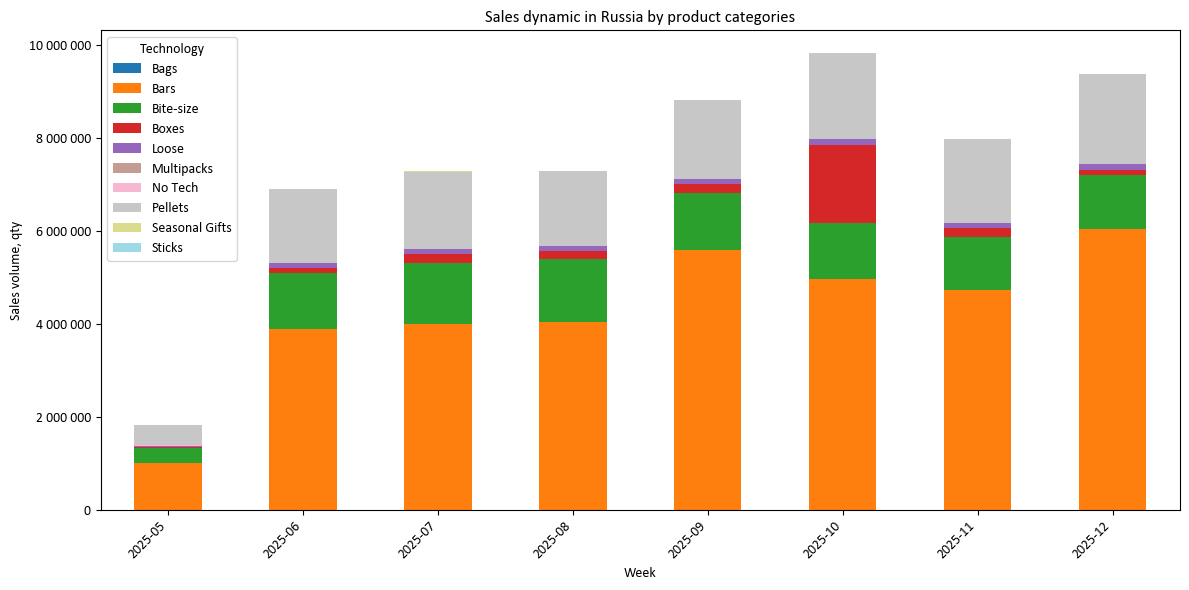

In [251]:
# Building stacked bar diagram
ax = pivot_data.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    colormap='tab20'
)


from matplotlib.ticker import FuncFormatter
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', ' ')))

plt.title('Sales dynamic in Russia by product categories')
plt.xlabel('Week')
plt.ylabel('Sales volume, qty')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [252]:
pivot_data_uraza_reg = uraza_regions.pivot_table(
    index='YearWeek',
    columns='Technology',
    values='Turnover Qty',
    aggfunc='sum',
    fill_value=0
)

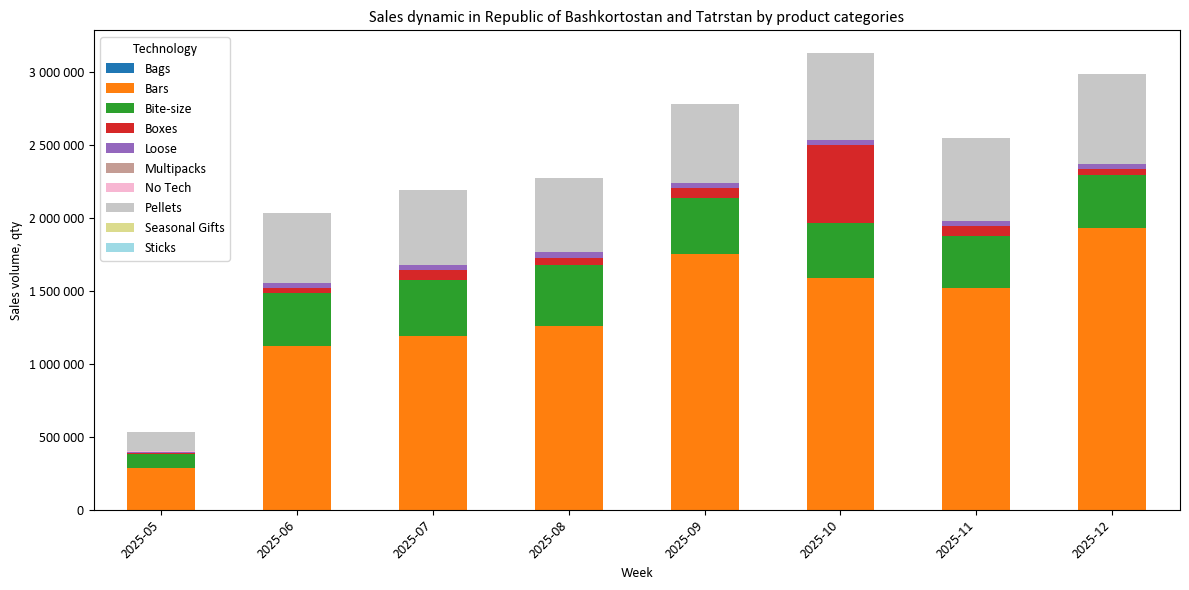

In [253]:
ax = pivot_data_uraza_reg.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    colormap='tab20'
)

from matplotlib.ticker import FuncFormatter
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', ' ')))

plt.title('Sales dynamic in Republic of Bashkortostan and Tatrstan by product categories')
plt.xlabel('Week')
plt.ylabel('Sales volume, qty')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [254]:
# Data for Tatarstan
tatar = uraza_regions.loc[uraza_regions['Outlet Region']=='Republic of Tatarstan (Tatarstan)',]
tatar.shape

(399, 5)

In [255]:
# data for Bashkortostan
bashkir = uraza_regions.loc[uraza_regions['Outlet Region']=='Republic of Bashkortostan',]
bashkir.shape

(394, 5)

In [256]:
# period of holiday Uraza in Tatarstan and Bashkortostan
uraza_during=uraza_regions[((uraza_regions['YearWeek']=='2025-09')|(uraza_regions['YearWeek']=='2025-10')|(uraza_regions['YearWeek']=='2025-11')|(uraza_regions['YearWeek']=='2025-12'))]

In [257]:
# period before holiday Uraza in Tatarstan and Bashkortostan
uraza_before = uraza_regions[((uraza_regions['YearWeek']=='2025-05')|(uraza_regions['YearWeek']=='2025-06')|(uraza_regions['YearWeek']=='2025-07')|(uraza_regions['YearWeek']=='2025-08'))]

In [258]:
data_not_uraza_regions = data[(data['Outlet Region']!='Republic of Tatarstan (Tatarstan)')|(data['Outlet Region']!='Republic of Bashkortostan')]
data_not_uraza_regions.shape

(4671, 5)

In [259]:
control_during = data_not_uraza_regions[((data_not_uraza_regions['YearWeek']=='2025-09')|(data_not_uraza_regions['YearWeek']=='2025-10')|(data_not_uraza_regions['YearWeek']=='2025-11')|(data_not_uraza_regions['YearWeek']=='2025-12'))]

In [260]:
control_before = data_not_uraza_regions[((data_not_uraza_regions['YearWeek']=='2025-05')|(data_not_uraza_regions['YearWeek']=='2025-06')|(data_not_uraza_regions['YearWeek']=='2025-07')|(data_not_uraza_regions['YearWeek']=='2025-08'))]

In [261]:
df = data.groupby(['YearWeek', 'Outlet Region'])['Turnover Qty'].mean().reset_index()

C:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Sales dynamic by regions of Russia')

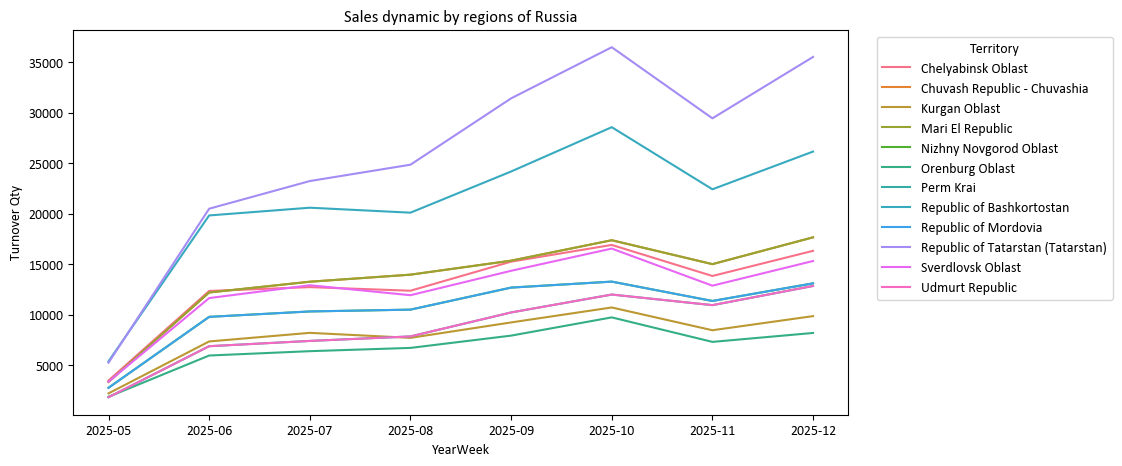

In [262]:
colors = ['#FFDA0E', '#8CBF3F', '#5653B0', '#268C5C', '#1FADBA', '#EBA808', '#AEADAD']

plt.rcParams['font.family'] = 'Calibri'  # Change 'serif' to your desired font (e.g., 'Times New Roman', 'Arial', etc.)
plt.rcParams['font.size'] = 10

# Plotting
plt.figure(figsize=(10, 5))
# Plot all regions except 'World'
ax = sns.lineplot(data=df, x='YearWeek', y='Turnover Qty', hue='Outlet Region')
ax.legend(title='Territory', loc='upper right', bbox_to_anchor=(1.35,1))

plt.title('Sales dynamic by regions of Russia')

C:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Sales dynamic in Tatarstan and Bashkortostan regions')

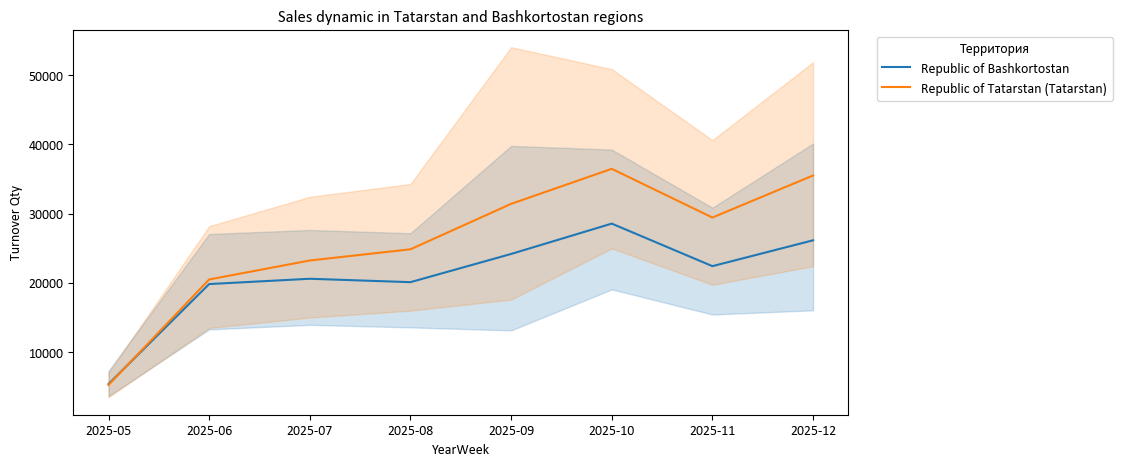

In [263]:
colors = ['#FFDA0E', '#8CBF3F', '#5653B0', '#268C5C', '#1FADBA', '#EBA808', '#AEADAD']

plt.rcParams['font.family'] = 'Calibri'  # Change 'serif' to your desired font (e.g., 'Times New Roman', 'Arial', etc.)
plt.rcParams['font.size'] = 10

# Plotting
plt.figure(figsize=(10, 5))
# Plot all regions except 'World'
ax = sns.lineplot(data=uraza_regions, x='YearWeek', y='Turnover Qty', hue='Outlet Region')

ax.legend(title='Территория', loc='upper right', bbox_to_anchor=(1.35,1))

plt.title('Sales dynamic in Tatarstan and Bashkortostan regions')

#### Conclusion

- The Republics of Tatarstan and Bashkortostan as a whole demonstrate higher sales compared to other regions
- During the holiday of Eid al-Fitr, they demonstrate significant growth in sales compared to other regions
- Top product categories by sales are Bars, Pellets, BiteSize and Boxes
- The peak of sales was reached during the holiday in the 10th week - the main contributor to sales growth is the Boxes category

## Hypothesis testing

- before_uraza - data on the Republic of Tatarstan and Bashkortostan before the holiday
- uraza - data on the Republic of Tatarstan and Bashkortostan during the holiday
--------------------------------------------------------------------------
- control_during - data on other regions during the holiday
- control_before - data on other regions before the holiday

<Axes: >

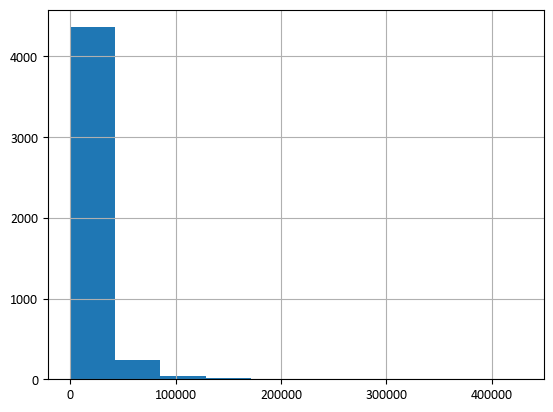

In [264]:
data['Turnover Qty'].hist()

In [265]:
before_uraza = uraza_before['Turnover Qty']

In [266]:
uraza = uraza_during['Turnover Qty']

In [267]:
control_during = control_during['Turnover Qty']

In [268]:
control_before = control_before['Turnover Qty']

### Bootstrap (the Republic of Tatarstan and Bashkortostan VS other regions)

To take into account changes in sales due to seasonality and other factors, we will first find the difference in the test (regions of Tatarstan and Bashkiria) and control samples (other regions) before and after the holiday. And then we will calculate the difference between the differences calculated in the previous step. DiD approach

In [269]:
def bootstrap_diff(group1_before, group1_after, group2_before, group2_after, n_iter=10000):
    np.random.seed(42)
    delta_list = []

    for _ in range(n_iter):
        sample1_before = np.random.choice(group1_before, size=len(group1_before), replace=True)
        sample1_after = np.random.choice(group1_after, size=len(group1_after), replace=True)
        sample2_before = np.random.choice(group2_before, size=len(group2_before), replace=True)
        sample2_after = np.random.choice(group2_after, size=len(group2_after), replace=True)

        delta1 = sample1_after.mean() - sample1_before.mean()
        delta2 = sample2_after.mean() - sample2_before.mean()

        delta_effect = delta1 - delta2
        delta_list.append(delta_effect)

    return delta_list

In [270]:
bootstrap_results = bootstrap_diff(before_uraza.values, uraza.values,
                                   control_before.values, control_during.values)

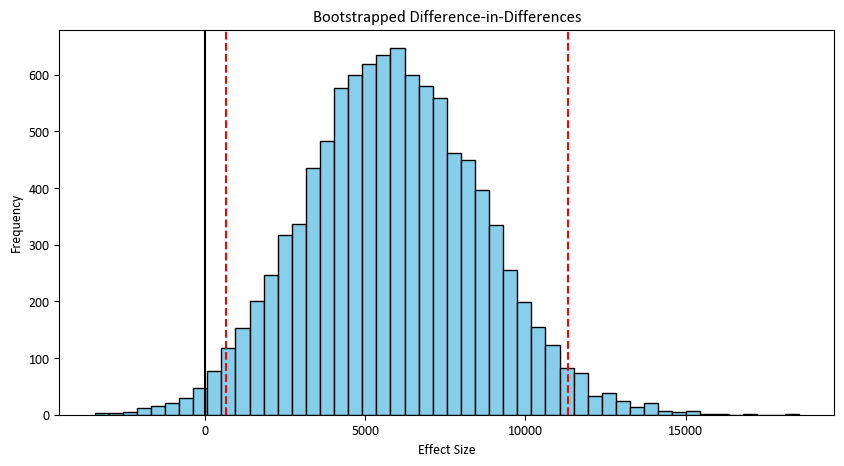

In [271]:
plt.figure(figsize=(10, 5))
plt.hist(bootstrap_results, bins=50, color='skyblue', edgecolor='k')
plt.axvline(x=np.percentile(bootstrap_results, 2.5), color='red', linestyle='--')
plt.axvline(x=np.percentile(bootstrap_results, 97.5), color='red', linestyle='--')
plt.axvline(x=0, color='black', linestyle='-')
plt.title("Bootstrapped Difference-in-Differences")
plt.xlabel("Effect Size")
plt.ylabel("Frequency")
plt.show()

In [272]:
ci_lower = np.percentile(bootstrap_results, 2.5)
ci_upper = np.percentile(bootstrap_results, 97.5)
mean_effect = np.mean(bootstrap_results)

In [273]:
print(f"Mean effect: {mean_effect:.2f}")
print(f"95% Confidence interval: [{ci_lower:.2f}, {ci_upper:.2f}]")

Mean effect: 5876.34
95% Confidence interval: [650.47, 11328.90]


In [274]:
if ci_lower > 0:
    print("✅ The growth in the test group is statistically significant.")
elif ci_upper < 0:
    print("🔻 The decline in the test group is statistically significant.")
else:
    print("❔ The change is not statistically significant.")

✅ The growth in the test group is statistically significant.


### Bootstrap (the Republic of Tatarstan VS other regions)

In [275]:
before_uraza_tatar = tatar[((tatar['YearWeek']=='2025-05')|(tatar['YearWeek']=='2025-06')|(tatar['YearWeek']=='2025-07')|(tatar['YearWeek']=='2025-08'))]['Turnover Qty']

In [276]:
during_uraza_tatar = tatar[((tatar['YearWeek']=='2025-09')|(tatar['YearWeek']=='2025-10')|(tatar['YearWeek']=='2025-11')|(tatar['YearWeek']=='2025-12'))]['Turnover Qty']

In [277]:
control_during = data[(data['Outlet Region']!='Republic of Tatarstan (Tatarstan)')&((data['YearWeek']=='2025-09')|(data['YearWeek']=='2025-10')|(data['YearWeek']=='2025-11')|(data['YearWeek']=='2025-12'))]['Turnover Qty']

In [278]:
control_before = data[(data['Outlet Region']!='Republic of Tatarstan (Tatarstan)')&((data['YearWeek']=='2025-05')|(data['YearWeek']=='2025-06')|(data['YearWeek']=='2025-07')|(data['YearWeek']=='2025-08'))]['Turnover Qty']

In [279]:
bootstrap_results = bootstrap_diff(before_uraza_tatar.values, during_uraza_tatar.values,
                                   control_before.values, control_during.values)

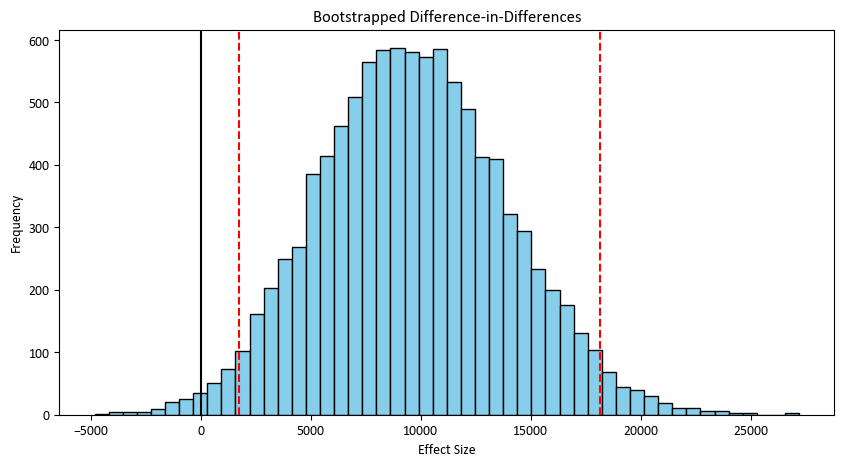

In [280]:
plt.figure(figsize=(10, 5))
plt.hist(bootstrap_results, bins=50, color='skyblue', edgecolor='k')
plt.axvline(x=np.percentile(bootstrap_results, 2.5), color='red', linestyle='--')
plt.axvline(x=np.percentile(bootstrap_results, 97.5), color='red', linestyle='--')
plt.axvline(x=0, color='black', linestyle='-')
plt.title("Bootstrapped Difference-in-Differences")
plt.xlabel("Effect Size")
plt.ylabel("Frequency")
plt.show()

In [281]:
ci_lower = np.percentile(bootstrap_results, 2.5)
ci_upper = np.percentile(bootstrap_results, 97.5)
mean_effect = np.mean(bootstrap_results)

In [282]:
print(f"Mean effect: {mean_effect:.2f}")
print(f"95% Confidence interval: [{ci_lower:.2f}, {ci_upper:.2f}]")

Mean effect: 9679.03
95% Confidence interval: [1735.78, 18128.13]


In [283]:
if ci_lower > 0:
    print("✅ The growth in the test group is statistically significant.")
elif ci_upper < 0:
    print("🔻 The decline in the test group is statistically significant.")
else:
    print("❔ The change is not statistically significant.")

✅ The growth in the test group is statistically significant.


### Bootstrap (the Republic of Bashkortostan VS other regions)

In [284]:
before_uraza_bashkir = bashkir[((bashkir['YearWeek']=='2025-05')|(bashkir['YearWeek']=='2025-06')|(bashkir['YearWeek']=='2025-07')|(bashkir['YearWeek']=='2025-08'))]['Turnover Qty']

In [285]:
during_uraza_bashkir = bashkir[((bashkir['YearWeek']=='2025-09')|(bashkir['YearWeek']=='2025-10')|(bashkir['YearWeek']=='2025-11')|(bashkir['YearWeek']=='2025-12'))]['Turnover Qty']

In [286]:
control_during = data[(data['Outlet Region']!='Republic of Bashkortostan')&((data['YearWeek']=='2025-09')|(data['YearWeek']=='2025-10')|(data['YearWeek']=='2025-11')|(data['YearWeek']=='2025-12'))]['Turnover Qty']

In [287]:
control_before = data[(data['Outlet Region']!='Republic of Bashkortostan')&((data['YearWeek']=='2025-05')|(data['YearWeek']=='2025-06')|(data['YearWeek']=='2025-07')|(data['YearWeek']=='2025-08'))]['Turnover Qty']

In [288]:
bootstrap_results = bootstrap_diff(before_uraza_bashkir.values, during_uraza_bashkir.values,
                                   control_before.values, control_during.values)

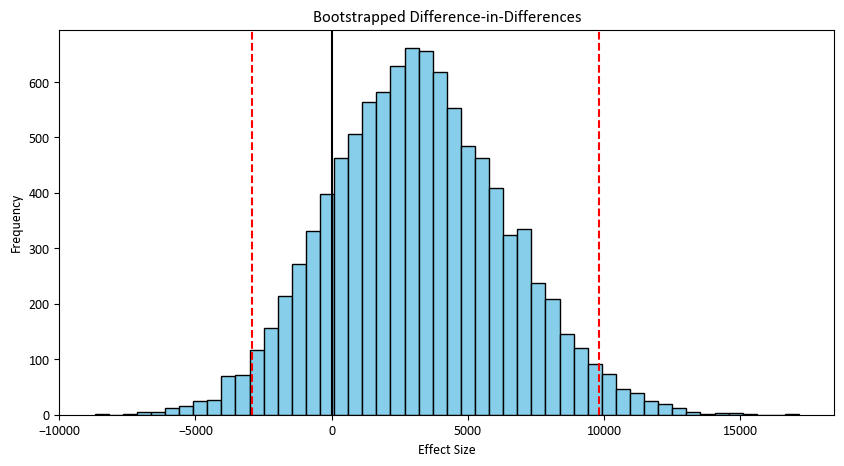

In [289]:
plt.figure(figsize=(10, 5))
plt.hist(bootstrap_results, bins=50, color='skyblue', edgecolor='k')
plt.axvline(x=np.percentile(bootstrap_results, 2.5), color='red', linestyle='--')
plt.axvline(x=np.percentile(bootstrap_results, 97.5), color='red', linestyle='--')
plt.axvline(x=0, color='black', linestyle='-')
plt.title("Bootstrapped Difference-in-Differences")
plt.xlabel("Effect Size")
plt.ylabel("Frequency")
plt.show()

In [290]:
ci_lower = np.percentile(bootstrap_results, 2.5)
ci_upper = np.percentile(bootstrap_results, 97.5)
mean_effect = np.mean(bootstrap_results)

In [291]:
print(f"Mean effect: {mean_effect:.2f}")
print(f"95% Confidence interval: [{ci_lower:.2f}, {ci_upper:.2f}]")

Mean effect: 3179.06
95% Confidence interval: [-2933.33, 9806.32]


In [292]:
if ci_lower > 0:
    print("✅ The growth in the test group is statistically significant.")
elif ci_upper < 0:
    print("🔻 The decline in the test group is statistically significant.")
else:
    print("❔ The change is not statistically significant.")

❔ The change is not statistically significant.


## Project Conclusion

- The **significant increase** in sales during muslim holiday Uraza-bayram is observed in **Tatarstan**
- The increase in **Bashcortostan** appears to be **insignificant compared** to the other region
- Therefore, while coordination of promo mechanics and thematic displays for Uraza-bayram holiday, management team should **prioritaise the Republic of Tatarstan**. Nethertheless, thematic activities may also significantly boost saless in the Republic of Bashkortostan due to the significant share of Muslim population.